In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io as sio
from data import IronDataset
import torchvision.transforms as tr
from torch.utils.data import DataLoader
from model import UNet, WPU_Net
from weight_map_loss import WeightMapLoss

12420
torch.Size([1, 256, 256])   torch.Size([1, 256, 256])   torch.Size([1, 256, 256])   [-6.         -5.7153645  -5.710275   ...  0.9999825   0.99999416
  1.        ]   torch.Size([2, 256, 256])   [ 0.3585759   0.35988447  0.36249724 ... 10.99999    11.
 30.        ]
0.4690565   -5.4199657


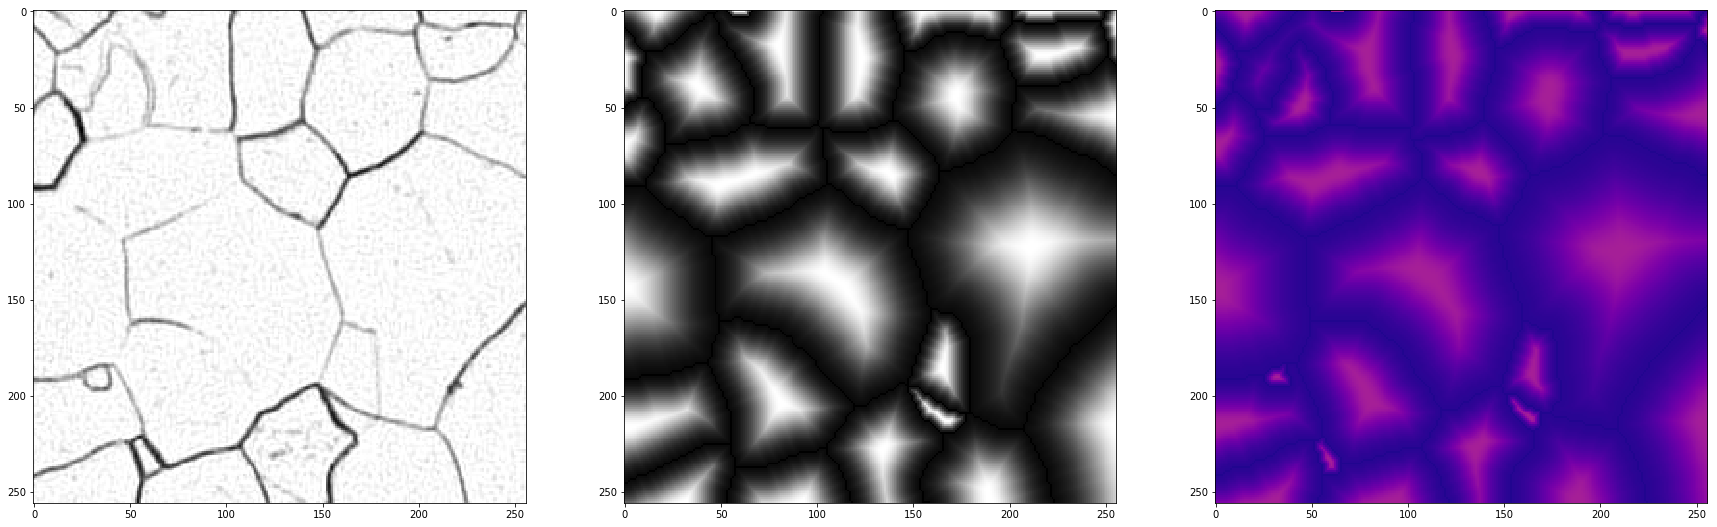

8700
torch.Size([1, 320, 224])   torch.Size([1, 320, 224])   torch.Size([1, 320, 224])   [-6.         -5.712076   -5.7085032  ...  0.99995995  0.9999858
  1.        ]   torch.Size([2, 320, 224])   [ 0.3585759   0.35903502  0.3600994  ... 10.999999   11.
 30.        ]
0.4690565   -6.468273


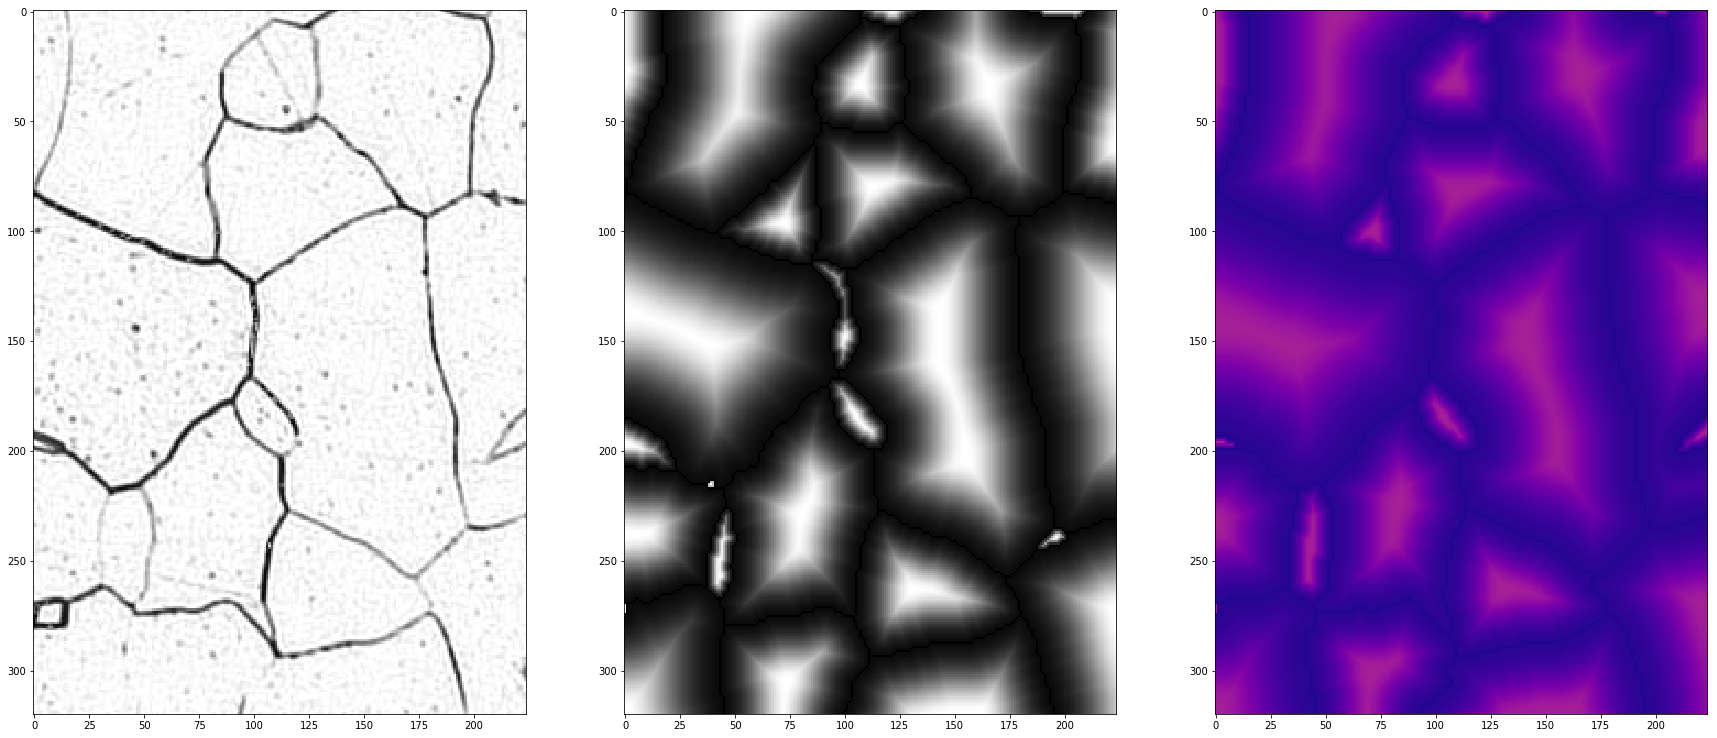

Training Data :  12420
Test Data : 8700


In [2]:
def check(dataset):   # check the output of dataset
    print(dataset.__len__())
    image, mask, last, weight = dataset.__getitem__(2)
    print(image.size(), " ", mask.size(), " ", last.size(), " ", np.unique(last), " ", weight.size(), " ", np.unique(weight))

    test_image = image.squeeze().numpy() 
    test_mask = mask.squeeze().numpy() 
    last_mask = last.squeeze().numpy() 
    test_weight = weight.squeeze().numpy()
    
    print(np.max(test_image), " ", np.min(test_image)) 

    plt.figure(figsize=(30,30))
    plt.subplot(2,2,1), plt.imshow(test_image, cmap="gray")
    plt.subplot(2,2,2), plt.imshow(test_mask, cmap="gray")
    plt.subplot(2,2,3), plt.imshow(last_mask, cmap="gray")
    plt.subplot(2,2,4), plt.imshow(test_weight[0, :, :], vmin=0, vmax=30, cmap="plasma")
    plt.show()


transform = tr.Compose([
    tr.ToTensor(),
    tr.Normalize(mean = [0.94034111, 0.94034111, 0.94034111], 
                std = [0.12718913, 0.12718913, 0.12718913])
])

DATA_FOLDER = "./datasets/"
train_dataset = IronDataset(DATA_FOLDER, train=True, transform=transform)
check(train_dataset)

batch_size = 24
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

test_dataset = IronDataset(DATA_FOLDER, train=False, transform=transform)
check(test_dataset)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)

print("Training Data : ", len(train_loader.dataset))
print("Test Data :", len(test_loader.dataset))

In [3]:
learning_rate = 1e-4
model = WPU_Net(num_channels=2, num_classes=2)
print(model)

# 初始化参数
def weights_init(m):
    classname = m.__class__.__name__ # 得到网络层的名字，如ConvTranspose2d
    if classname.find('Conv2d') != -1:
        nn.init.xavier_uniform_(m.weight.data)
model.apply(weights_init)

if torch.cuda.is_available():
    model = nn.DataParallel(model).cuda()

optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.9, eps=1e-5) 

criterion=WeightMapLoss(_dilate_cof=5)
method = 4

UNet_variant_six_attention(
  (down1): Conv3x3(
    (conv1): Sequential(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (down2): Conv3x3(
    (conv1): Sequential(
      (0): Conv2d(65, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (down3): Conv3x3(
    (conv1): Sequential(
      (

In [4]:
import torch.nn.functional as F
from skimage import morphology

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by half every 10 epochs until 1e-5"""
    lr = learning_rate * (0.8 ** (epoch // 10))
    if not lr < 1e-6:
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

def train(net, epoch, loss_list, plotimgs):
    net.train()
    adjust_learning_rate(optimizer, epoch)
    iterations=int(len(train_loader.dataset)/batch_size)
    for batch_idx, (image, mask, last, weight) in enumerate(train_loader):
        images=[]
        label = mask.squeeze(1).type(torch.LongTensor)
        
        if torch.cuda.is_available():
            img, label ,last, weight= image.cuda(), label.cuda(), last.cuda(), weight.cuda()
            
        optimizer.zero_grad()
        output = net(img, last, is_up1=True)
        loss = criterion(output, label, weight, method=method)
        loss.backward()
        # 梯度裁剪
        nn.utils.clip_grad_norm_(net.parameters(), 5)
        optimizer.step()

        if (batch_idx+1) % iterations == 0:
            loss_list.append(float(loss.item()))
            
            # Display the output image of the intermediate process
            if plotimgs :
                images.append(image[0].squeeze().numpy())
                images.append(mask[0].squeeze().numpy())
                out = torch.sigmoid(output[0])
                result_npy = out.max(0)[1].data.squeeze().cpu().numpy()
                result_npy = np.array(result_npy).astype('uint8')*255
                images.append(result_npy)
                result_npy_nc = morphology.skeletonize(result_npy / 255) * 255  # 骨架化 Skeletonization
                images.append(result_npy_nc)
                
                # [0] original  [1] mask  [2] result [3] result_fc
                plot_imgs(str(epoch).zfill(3)+'_train',images)

def test(net, test_loss_list):
    net.eval()
    test_loss = 0
    images=[]
    for batch_idx, (image, mask, last, weight) in enumerate(test_loader): 
        # set the first 8 images of test set to validation set    
        # the num is 800 here as each full size image in the test set is cut into 100 small images according to the overlap-tile strategy.
        if batch_idx < 800: 
            if torch.cuda.is_available():
                label = mask.squeeze(1).type(torch.LongTensor)
                img, label, last, weight= image.cuda(), label.cuda(), last.cuda(), weight.cuda()
            
            output = net(img, last, is_up1=True)
            test_loss += float(criterion(output, label, weight, method=method).item())
            if batch_idx==1:
                images.append(image.squeeze().numpy())
                images.append(mask.squeeze().numpy())
                out = torch.sigmoid(output)
                result_npy = out.max(1)[1].data.squeeze().cpu().numpy()
                result_npy = np.array(result_npy).astype('uint8')*255
                images.append(result_npy)
                result_npy_nc = morphology.skeletonize(result_npy / 255) * 255  # 骨架化
                images.append(result_npy_nc)
        else:
            break
    
    # Average WCE loss
    test_loss /= 800
    test_loss_list.append(test_loss)
    return test_loss, images



In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time 

  
def plot_imgs(title, imgs):
 
    plt.figure(figsize=(30,30))
    plt.subplot(221)
    plt.imshow(imgs[0], cmap ='gray')
    plt.axis('off')
    plt.title(title+'_img-label-out-skle')
    plt.subplot(222)
    plt.imshow(imgs[1], cmap ='gray')
    plt.axis('off')
    plt.subplot(223)
    plt.imshow(imgs[2], cmap ='gray')
    plt.axis('off')
    plt.subplot(224)
    plt.imshow(imgs[3], cmap ='gray')
    plt.axis('off')
    plt.savefig(checkpoint_path+str(title)+'.png')
    
def plot(epoch, loss_list, test_loss_list):
    clear_output(True)
    plt.figure()
    plt.title('epoch %s. train loss: %s. val_loss: %s' % (epoch, loss_list[-1], test_loss_list[-1]))
    plt.plot(loss_list, color="r", label="train loss")
    plt.plot(test_loss_list, color="b", label="val loss")
    plt.legend(loc="best")
    plt.savefig(checkpoint_path+'test_model_loss_state.png')
    plt.show()
    
loss_list = []
test_loss_list = []
epochs = 10 
test_baseline = 10000

# model save address
checkpoint_path='./model/'
if not os.path.exists(checkpoint_path):
    os.mkdir(checkpoint_path) 

for i in range(1,epochs+1):
    plotimgs = True
    train(model, i, loss_list, plotimgs)
    test_loss, imgs = test(model, test_loss_list)
    f=open(checkpoint_path+'loss.txt','a') 
    f.write("epoch %d:loss %f \n"%(i,loss_list[-1]))
    f.write("epoch %d:loss %f test_loss %f\n"%(i,loss_list[-1],test_loss_list[-1]))
    f.close()
    plot(i, loss_list, test_loss_list)
    plot_imgs(str(i).zfill(3)+'_test', imgs)
    torch.save(model.state_dict(), checkpoint_path+str(i)+'_epoch'+'.pth')
    if test_loss < test_baseline:
        test_baseline = test_loss
        torch.save(model.state_dict(), checkpoint_path+"best_unet_model_state.pth")